## Power Usage Forecasting Project

IN this notebook we'll study how to develop and evaluate naive models for forecasting time series problems.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

%matplotlib inline

In [165]:
from math import sqrt
from numpy import split, array
from sklearn.metrics import mean_squared_error
from statistics import mean

In [3]:
# check the files
!ls

Naive_Models.ipynb    daily_power.csv       power_cleaned.csv
README.md             data                  power_usage_eda.ipynb


In [4]:
# what's in data file
os.listdir("data")

['.DS_Store',
 'household_power_consumption.txt',
 'household_power_consumption.zip']

In [56]:
# Read in our prepared daily dataset
daily = pd.read_csv("daily_power.csv", header=0, infer_datetime_format=True, 
                    parse_dates=["datetime"], index_col=["datetime"])

In [57]:
daily.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
datetime,,,,,,,,
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0,14680.933319
2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0,36946.666732
2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0,19028.433281
2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0,6197.0,13131.900043
2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0,14063.0,20384.800011


## Evaluation Metric

A forecast will be comprised of seven values, one for each day of the week ahead. We'll use RMSE as the metric as we want to use this as a baseline for our project RMSE metric.

1. First we'll build a model that will take real and predicted value and return an average score and a list of the individual daily scores.

In [58]:
# Create a function that returns the performance of a model based on multiple seven day forecasts.
def evaluate_forecast(actual, predicted):
    scores = list()
    # Calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # Calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # Calculate rmse
        rmse = sqrt(mse)
        # store in the scores list
        scores.append(rmse)
    # Calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row,col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

## Train Test Split

2. Now we'll split the data into train and test sets. We'll take the first three years as training data and the finsl years as test data. This is a repeat of the code from the main project notebook -- see the project notebook for more detail on how the split is created.

In [59]:
# Create a function to split the data at the required date ranges
def split_dataset(data):
    # Split into standard weeks
    train, test = data[1:-328], data[-328:-6]
    # Restructure into windows of weekly data
    train = array(split(train, len(train)/7))
    test = array(split(test, len(test)/7)) 
    # this creates an array of shape (46, 7, 8) 46 periods, 7 days, 8 features
    
    return train, test

## Walk Forward Validation
Walk-forward validation is where a model is required to make a prediction, then the actual data for that data point is make available to the model so that it can be used as the basis for making a prediction on the subsequent data point. This is realistic for time series problems as the last data point would indeed be available to inform the next prediction. 

3. Build a model evaluation function that handles the model prediction data and passes it to our forecast function for scoring.

In [60]:
def evaluate_model(model_func, train, test):
    # history is a list of weekly data
    history = [x for x in train]
    # Walk-forward validation over each week
    predictions = list()
    for i in range(len(test)): # 46 periods of seven days
        # Make weekly predictions
        yhat_sequence = model_func(history)
        # Store the predictions
        predictions.append(yhat_sequence)
        # Get real observation and add to history for predicting the next week
        history.append(test[i, :])
    # Evaluate predictions days for each week
    predictions = array(predictions)
    score, scores = evaluate_forecast(test[:, :, 0], predictions) # we extracte the first feature at pos=0, our target
    
    return score, scores

### Narrative on the ebvaluate model function.
1. Whenever we pass the history to the model function we let the model function decide which part of the history we're interested in.
2. If it's last week then we query `history[-1]` as that the last day of history
3. If it's this week but a year ago then `history[-52]`
4. Once we've undertaken one prediction we append the following week to the recorded history. 
5. Therefore `history[1] history[-52]` etc etc return different values for each iteration.

4. Summarize the performance

In [61]:
# Create a function that will display the performance of a model as singe line for easy comparisons
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f'% s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))

## Naive Forecast Models
Let's develop our naive models

We'll create three separate naive models based on the following methods:
1. Daily persistence forecast
2. Weekly persistent forecast
3. Weekly One-Year-Ago Persistant forecast

#### Daily Persistence Forecast
This method takes the last day from the previous seven day period and uses it to forecast each of the following seven days. 

In [62]:
# daily persistence
def daily_persistence(history):
    # get the data for the prior week
    last_week = history[-1]
    # get the total active power for the last day
    value = last_week[-1,0]
    # prepare 7 day forecast
    forecast = [value for _ in range(7)]
    return forecast

#### Weekly Persistence Forecast
This method takes the prior seven day period and uses it to predict each of the next seven days.

In [63]:
# Weekly Persistence
def weekly_persistence(history):
    # get the data for the prior week
    last_week = history[-1]
    return last_week[:, 0]

#### Weekly One-Year-Ago Persistent Forecast
This method takes the values from the same seven day period but one year ago based on the likelihood that they will have similar daily values.

In [64]:
# week one year ago perstistence
def week_year_ago(history):
    # get the data for the week one year ago
    last_week = history[-52]
    return last_week[:,0]

#### Further Steps - mean daily persistence
This method takes the mean of the last 7 days and forecasts that for the next 7 days

In [168]:
def mean_daily_persistence(history):
    # get the data for the prior week
    last_week = history[-1]
    # get the mean active power for the last seven days
    value = mean(list(last_period[:, 0]))
    # prepare 7 day forecast based on the mean
    forecast = [value for _ in range(7)]
    return forecast

## Prepare the data, run models and evaluate

1. Split data into training and test sets

In [65]:
# Call our splitting function
train, test = split_dataset(daily.values)

2. Lets store each naive method in a dictionary to make evaluation more straightforward

In [169]:
# define names for each method and store in a dictionary
models = dict()
models['daily'] = daily_persistence
models['weekly'] = weekly_persistence
models['week-oya'] = week_year_ago
models['mean_daily'] = mean_daily_persistence

3. Evaluate each strategy, printing the average RMSE score and the daily scores (7 days) and diaplay a plot

daily: [511.886] 452.9, 596.4, 532.1, 490.5, 534.3, 481.5, 482.0
weekly: [469.389] 567.6, 500.3, 411.2, 466.1, 471.9, 358.3, 482.0
week-oya: [465.294] 550.0, 446.7, 398.6, 487.0, 459.3, 313.5, 555.1
mean_daily: [631.530] 594.3, 651.1, 634.4, 630.4, 651.5, 615.6, 641.5
Optimal Naive RMSE: 431.305256101362


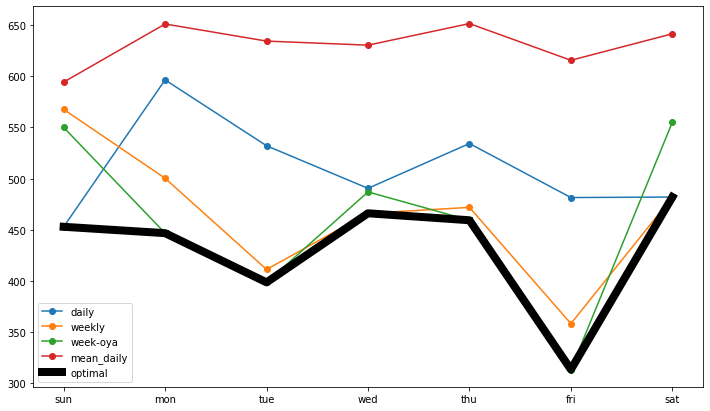

In [200]:
# create a list of the days of the week
days = ["sun", "mon", "tue", "wed", "thu", "fri", "sat"]
optimal = [1000, 1000, 1000, 1000, 1000, 1000, 1000]

plt.figure(figsize=(12,7))

# Iterate through our model dictionary and pass the values through our evaluation functions
for name, func in models.items():
    # evaluate and get scores
    score, scores = evaluate_model(func, train, test)
    # summarize scores using our summary function
    summarize_scores(name, score, scores)
    
    # Calculate and store the best performing model for each day
    for i,j in enumerate(scores):
        if j < optimal[i]:
            optimal[i] = j
        else:
            continue
            
    # Plot the base model scores
    plt.plot(days, scores, marker='o', label=name)
    
    
# plot the optimal scores
print(f'Optimal Naive RMSE: {mean(optimal)}')
plt.plot(days, optimal, marker="v", label="optimal", linewidth=8, color="k")
plt.legend()

### Optimized daily persistence model
To do this we'll need to creata a model for each of the previous seven days. The we can evaluate each of the daily models to decide which day has the most predictive power.

In [671]:
# daily persistence

# Create a list to hold all our predictions - this should be 46*7*7 = 2254 items long
lst = []
def daily_optimized(history):
    global lst # Make the list accessibkle from within this function
    #daily_vals = []
    # get the data for the prior week
    last_week = history[-1]
    # get the total active power for the last day
    for k in range(8):
        if k == 0:
            continue
        else:
            # Get the values for the last seven days
            value = last_week[-k,0]
            # For each daily value, make this the forecast for all days of the following week
            forecast = [value for _ in range(7)]
            # Append the forecasts to our global list
            lst.append(forecast)     
    return None

We can use the same model evaluation function as we were originally using. 

In [672]:
def evaluate_model(model_func, train, test):
    # history is a list of weekly data
    history = [x for x in train]
    # Walk-forward validation over each week
    predictions = list()
    for i in range(len(test)): # 46 periods of seven days
        # Make weekly predictions
        yhat_sequence = model_func(history)
        # Store the predictions
        predictions.append(yhat_sequence)
        # Get real observation and add to history for predicting the next week
        history.append(test[i, :])
    # Evaluate predictions days for each week
    predictions = array(predictions)
#     score, scores = evaluate_forecast(test[:, :, 0], predictions) # we extracte the first feature at pos=0, our target
    
    return None

Call the functions. Note there is no returned output. But our list should now be fully poplulated. 

In [673]:
evaluate_model(daily_optimized, train, test)

In [647]:
# Check our revised list
lst

[[1309.2679999999998,
  1309.2679999999998,
  1309.2679999999998,
  1309.2679999999998,
  1309.2679999999998,
  1309.2679999999998,
  1309.2679999999998],
 [1224.2519999999988,
  1224.2519999999988,
  1224.2519999999988,
  1224.2519999999988,
  1224.2519999999988,
  1224.2519999999988,
  1224.2519999999988],
 [2211.892000000002,
  2211.892000000002,
  2211.892000000002,
  2211.892000000002,
  2211.892000000002,
  2211.892000000002,
  2211.892000000002],
 [2451.110000000003,
  2451.110000000003,
  2451.110000000003,
  2451.110000000003,
  2451.110000000003,
  2451.110000000003,
  2451.110000000003],
 [2047.968000000001,
  2047.968000000001,
  2047.968000000001,
  2047.968000000001,
  2047.968000000001,
  2047.968000000001,
  2047.968000000001],
 [2094.097999999999,
  2094.097999999999,
  2094.097999999999,
  2094.097999999999,
  2094.097999999999,
  2094.097999999999,
  2094.097999999999],
 [2195.4520000000025,
  2195.4520000000025,
  2195.4520000000025,
  2195.4520000000025,
  2195.452

In [648]:
# Check the length of the list - 322*7 == 2254
len(lst)

322

In [649]:
# Convert our list to an array
lstA = np.array(lst)

In [650]:
# Reverse the order of our days list created above. our method looks back from saturday - sunday
weekdays = days[::-1]

In [651]:
weekdays # new order

['sat', 'fri', 'thu', 'wed', 'tue', 'mon', 'sun']

In [652]:
df = pd.DataFrame(lstA, columns=weekdays)

df # Note that our dataframe is not oriented correctly, we need the daily predictions to run vertically

,sat,fri,thu,wed,tue,mon,sun
0,1309.268,1309.268,1309.268,1309.268,1309.268,1309.268,1309.268
1,1224.252,1224.252,1224.252,1224.252,1224.252,1224.252,1224.252
2,2211.892,2211.892,2211.892,2211.892,2211.892,2211.892,2211.892
3,2451.110,2451.110,2451.110,2451.110,2451.110,2451.110,2451.110
4,2047.968,2047.968,2047.968,2047.968,2047.968,2047.968,2047.968
...,...,...,...,...,...,...,...
317,1773.592,1773.592,1773.592,1773.592,1773.592,1773.592,1773.592
318,1946.534,1946.534,1946.534,1946.534,1946.534,1946.534,1946.534
319,2022.098,2022.098,2022.098,2022.098,2022.098,2022.098,2022.098
320,1825.540,1825.540,1825.540,1825.540,1825.540,1825.540,1825.540


Unfortunately this cannot be achieved with a simple reshape so we'll have to reorganise manually

In [653]:
# Create a list to iterate thro', note we start on the second we as the first weekly results are saved in the data
# variable below
week_index = list(range(7,322))

week_index

[7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189

In [654]:
# Set an initial dataframe to hold the results - save the first weeks results to it.
data = df.loc[0:6].T
for i, j in enumerate(week_index):
    
    if j % 7 != 0: # We're iterating in a rolling 7 day window, we want to ignore all interim values
        continue
    else :
        # Set a start day and end day
        start = j
        finish = week_index[i+6] 
        
        # store the next week of rolling results and append it to the main data set
        next_week = df.loc[start:finish].T
        next_week.columns = data.columns
        data = pd.concat([data, next_week], axis=0)


In [655]:
data # Boom!

,0,1,2,3,4,5,6
sat,1309.268,1224.252,2211.892,2451.110,2047.968,2094.098,2195.452
fri,1309.268,1224.252,2211.892,2451.110,2047.968,2094.098,2195.452
thu,1309.268,1224.252,2211.892,2451.110,2047.968,2094.098,2195.452
wed,1309.268,1224.252,2211.892,2451.110,2047.968,2094.098,2195.452
tue,1309.268,1224.252,2211.892,2451.110,2047.968,2094.098,2195.452
...,...,...,...,...,...,...,...
thu,2023.174,1836.822,1773.592,1946.534,2022.098,1825.540,1673.816
wed,2023.174,1836.822,1773.592,1946.534,2022.098,1825.540,1673.816
tue,2023.174,1836.822,1773.592,1946.534,2022.098,1825.540,1673.816
mon,2023.174,1836.822,1773.592,1946.534,2022.098,1825.540,1673.816


In [656]:
# Change the column headers to suit the days of the week
data.columns = df.columns

In [657]:
data

,sat,fri,thu,wed,tue,mon,sun
sat,1309.268,1224.252,2211.892,2451.110,2047.968,2094.098,2195.452
fri,1309.268,1224.252,2211.892,2451.110,2047.968,2094.098,2195.452
thu,1309.268,1224.252,2211.892,2451.110,2047.968,2094.098,2195.452
wed,1309.268,1224.252,2211.892,2451.110,2047.968,2094.098,2195.452
tue,1309.268,1224.252,2211.892,2451.110,2047.968,2094.098,2195.452
...,...,...,...,...,...,...,...
thu,2023.174,1836.822,1773.592,1946.534,2022.098,1825.540,1673.816
wed,2023.174,1836.822,1773.592,1946.534,2022.098,1825.540,1673.816
tue,2023.174,1836.822,1773.592,1946.534,2022.098,1825.540,1673.816
mon,2023.174,1836.822,1773.592,1946.534,2022.098,1825.540,1673.816


In [658]:
# prepare the test set as we'll now join these to the dataset
test_set = test[:, :, 0]
test_set.shape

(46, 7)

In [659]:
# reshape into a 1D list
actual = test_set.reshape(322,1)

In [660]:
actual = actual.tolist()

In [661]:
# Convert into a dataframe so we can join easily
actual = pd.DataFrame(actual, columns=["actual"])

In [662]:
actual

,actual
0,2083.454
1,1604.132
2,2219.780
3,1777.180
4,1769.442
...,...
317,1509.748
318,1582.032
319,1652.152
320,1570.400


In [663]:
# reset our data index so we can join on the index values - we'll keep the days of the week as reference in a feature
datax = data.reset_index()

In [664]:
datax

,index,sat,fri,thu,wed,tue,mon,sun
0,sat,1309.268,1224.252,2211.892,2451.110,2047.968,2094.098,2195.452
1,fri,1309.268,1224.252,2211.892,2451.110,2047.968,2094.098,2195.452
2,thu,1309.268,1224.252,2211.892,2451.110,2047.968,2094.098,2195.452
3,wed,1309.268,1224.252,2211.892,2451.110,2047.968,2094.098,2195.452
4,tue,1309.268,1224.252,2211.892,2451.110,2047.968,2094.098,2195.452
...,...,...,...,...,...,...,...,...
317,thu,2023.174,1836.822,1773.592,1946.534,2022.098,1825.540,1673.816
318,wed,2023.174,1836.822,1773.592,1946.534,2022.098,1825.540,1673.816
319,tue,2023.174,1836.822,1773.592,1946.534,2022.098,1825.540,1673.816
320,mon,2023.174,1836.822,1773.592,1946.534,2022.098,1825.540,1673.816


In [665]:
# Join the dfs
datax = datax.join(actual)

In [675]:
datax.head(10)
# Note that the second saturday (row) value is the same as the first sunday (row) value. As required!

,index,sat,fri,thu,wed,tue,mon,sun,actual,tempsqerr
0,sat,1309.268,1224.252,2211.892,2451.11,2047.968,2094.098,2195.452,2083.454,12543.552004
1,fri,1309.268,1224.252,2211.892,2451.11,2047.968,2094.098,2195.452,1604.132,349659.342400
2,thu,1309.268,1224.252,2211.892,2451.11,2047.968,2094.098,2195.452,2219.780,591.851584
3,wed,1309.268,1224.252,2211.892,2451.11,2047.968,2094.098,2195.452,1777.180,174951.465984
4,tue,1309.268,1224.252,2211.892,2451.11,2047.968,2094.098,2195.452,1769.442,181484.520100
5,mon,1309.268,1224.252,2211.892,2451.11,2047.968,2094.098,2195.452,1797.208,158598.283536
6,sun,1309.268,1224.252,2211.892,2451.11,2047.968,2094.098,2195.452,2336.900,20007.536704
7,sat,2336.900,1797.208,1769.442,1777.18,2219.780,1604.132,2083.454,2508.466,180635.200144
8,fri,2336.900,1797.208,1769.442,1777.18,2219.780,1604.132,2083.454,1518.684,318965.152900
9,thu,2336.900,1797.208,1769.442,1777.18,2219.780,1604.132,2083.454,1995.796,7683.924964


Now we need to calculate the RMSE for each set of daily results to see which day is the best predictor for the following days
1. create a new column to take the squared error of each data point
2. create a variable to store the root mean of this squared error
3. Compare the results and select a winner


In [667]:
weekdays

['sat', 'fri', 'thu', 'wed', 'tue', 'mon', 'sun']

In [668]:
# Create and empty RMSE list to store the 7 daily results
rmse_list = []
# Loop through the daily columns to calculate the RMSE for each feature against actual values.
for i in range(7):
    # Set the current day to a variable
    day = weekdays[i]
    # Create a temp column that will hold the individual error values
    datax["tempsqerr"] = (datax[day]-datax["actual"])**2
    # Get the mean value of this feature
    mse = datax["tempsqerr"].mean()
    # append the root of the mse to our global list
    rmse_list.append(sqrt(mse))

In [669]:
rmse_list

[511.88625839478846,
 423.0913477089773,
 467.22416145089375,
 485.3193459338546,
 455.0001519468864,
 492.1409738916849,
 530.1777717831134]

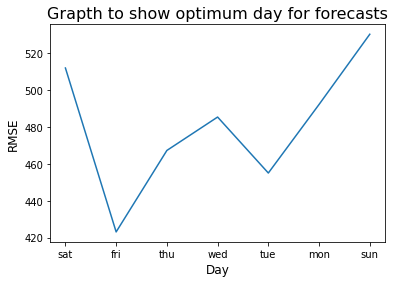

In [670]:
# Plot the daily results
plt.plot(weekdays, rmse_list)
plt.title("Grapth to show optimum day for forecasts", fontsize=16);
plt.ylabel("RMSE", fontsize=12)
plt.xlabel("Day", fontsize=12);


### Results
1. Friday is the best performing single day forecaster on a naive basis with rmse of 423
2. Sunday is the worst performing single day forecaster on a naive basis with rmse of 530

### Final Narrative
1. The best single model is the weekly one year ago with an RMSE of 465
2. The optimal model taking the best model results for each day gives an RMSE of 431
3. The optimize daily persistence model shows that Friday has the best forecasting accuracy: RMSE of 423

## Next Steps
How far can you take naive forecasting? It looks like using Friday in isolation actually produces the best results of all the naive models we've investigated. It's clear to see that Saturday and Sunday are the worst which suggest power usage on these days is toward the outside of the variance scale which makes some sense given that they are weekend days but in the minority in terms of data points. Obviously we have 5 weekdays and only 2 weekend days. Maybe there's something to be said about Friday is the end of the week and beginning of the weekend so shares similarities with both and therefore was always likely to be a good predictor!! 

**We'll leave it there for now!!!**